# Titanic

In [188]:
#Pandas is for dataframe manipulation
import pandas as pd 
#Scikit learn is used to build the model. It has various libraries like linear regression, decision tree etc.
from sklearn.linear_model import LogisticRegression
import numpy as np 
# import matplotlib.pyplot as plt #I did not use this
from sklearn.preprocessing import StandardScaler #used for standardization (sometimes called Z-score normalization)
# from sklearn.model_selection import train_test_split # Do not need this with the multiple datasets kaggle has given

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score


In [189]:
#load the data into dataframes
#data retrieved from kaggle competitions
train = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

In [190]:
#will focus on train data for now. 
gender_submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [191]:
#Merge the gender_submission database and the test_df database since they were given by kaggle
#but contain incomplete data in comparision to the train dataframe. This merge consolidates for further manipulation
test = pd.merge(test_df, gender_submission, on = "PassengerId", how="inner")
test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


Going to need to apply any column changes to test and train. gender_submissions will be what we apply at the end with passenger IDs matching

In [192]:
# We need to turn the Pclass into its own columns in order to get a better prediction on who will be in what class
train['FirstClass'] = train.Pclass.apply(lambda p: 1 if p == 1 else 0)
test['FirstClass'] = test.Pclass.apply(lambda p: 1 if p == 1 else 0)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [193]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,FirstClass
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0


In [194]:
# Now the same thing for second class and then again for third class people. 
# We need to turn the Pclass into its own columns in order to get a better prediction on who will be in what class
train['SecondClass'] = train.Pclass.apply( lambda p: 1 if p == 2 else 0)
test['SecondClass'] = test.Pclass.apply( lambda p: 1 if p == 2 else 0)
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass,SecondClass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0,1


In [195]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,FirstClass,SecondClass
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0,0


In [196]:
train['ThirdClass'] = train.Pclass.apply( lambda p: 1 if p == 3 else 0)
test['ThirdClass'] = test.Pclass.apply( lambda p: 1 if p == 3 else 0)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass,SecondClass,ThirdClass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1


In [197]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,FirstClass,SecondClass,ThirdClass
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0,0,1


We know from stories of Titanic that women and children  can be saved in a life raft, but what about men? 
I think we should address gender and age next as it may help our model. 

In [198]:
# Let's make the sex cloumn into a binary column
train['Sex_binary'] = train.Sex.map({"male": 0, "female": 1}) 
test['Sex_binary'] = test.Sex.map({"male": 0, "female": 1})
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass,SecondClass,ThirdClass,Sex_binary
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0


I could of done this earlier, but in this data, I am not likely to use the following columns right now. I may need them later for further analysis but at present they are just cluttering up my dataset. Lets just drop them for now from each dataframe.

Pclass, Name, SibSp, Parch, Ticket, Fare, Cabin, Embarked

In [199]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FirstClass,SecondClass,ThirdClass,Sex_binary
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.034303,-0.000086,-0.029486,-0.042939
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.285904,0.093349,-0.322308,0.543351
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.885924,-0.188432,0.916673,-0.131900
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.348941,0.006954,-0.312271,-0.093254
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.054582,-0.055932,0.092548,0.114631
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.017633,-0.000734,0.015790,0.245489
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.591711,-0.118557,-0.413333,0.182333
FirstClass,0.034303,0.285904,-0.885924,0.348941,-0.054582,-0.017633,0.591711,1.000000,-0.288585,-0.626738,0.098013
SecondClass,-0.000086,0.093349,-0.188432,0.006954,-0.055932,-0.000734,-0.118557,-0.288585,1.000000,-0.565210,0.064746
ThirdClass,-0.029486,-0.322308,0.916673,-0.312271,0.092548,0.015790,-0.413333,-0.626738,-0.565210,1.000000,-0.137143


In [200]:
# columns_to_drop = ["Pclass", "Name", "Sex", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
columns_to_drop = ["Pclass", "Name", "Sex",  "Ticket", "Cabin", "Embarked"]

train = train.drop(columns_to_drop, axis = 1)
test = test.drop(columns_to_drop, axis = 1)
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FirstClass,SecondClass,ThirdClass,Sex_binary
0,1,0,22.0,1,0,7.2500,0,0,1,0
1,2,1,38.0,1,0,71.2833,1,0,0,1
2,3,1,26.0,0,0,7.9250,0,0,1,1
3,4,1,35.0,1,0,53.1000,1,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0


In [115]:
train.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FirstClass,SecondClass,ThirdClass,Sex_binary
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208,0.242424,0.206510,0.551066,0.352413
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429,0.428790,0.405028,0.497665,0.477990
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


In [201]:
train["Age"].count()
# we have 714 rows with an age. So we have some missing data. We have 891 rows 

714

## Types of missing data:
- **Missing Completely at Random (MCAR):** No pattern to the missingness.
- **Missing at Random (MAR):** Missingness might be related to other observed variables, but not the missing value itself.
- **Missing Not at Random (MNAR):** The missingness depends on the value of the missing data itself.

## Strategies for Handling Missing Values

- **Listwise Deletion:** Remove rows containing missing values. Use with caution, especially if you have a large number of missing entries, as you could lose valuable information.
- **Pairwise Deletion:** Utilize all available data, but computations might involve different subsets of data.
- **Imputation:** Fill in missing values with estimated substitutes. **Common methods:**
- **Mean/Median Imputation:** Replace missing values with the mean/median of the column. Suitable for numerical data.
- **Mode Imputation:** Replace missing categorical values with the most frequent category.
- **Predictive Modeling:** Create a model to predict missing values based on other variables. This can be more sophisticated.


This is an exert summary from google's Gemini

In [202]:
#Let's fill in the ages with the mean of all ages.
train['Age'].fillna(value = round(train['Age'].mean()), inplace = True) #look up .fillna function
test['Age'].fillna(value = round(test['Age'].mean()), inplace = True) 
train["Age"].count() #now we have every row accounted for. 

891

In [118]:
train.describe() 

,PassengerId,Survived,Age,SibSp,Parch,Fare,FirstClass,SecondClass,ThirdClass,Sex_binary
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.758889,0.523008,0.381594,32.204208,0.242424,0.206510,0.551066,0.352413
std,257.353842,0.486592,13.002570,1.102743,0.806057,49.693429,0.428790,0.405028,0.497665,0.477990
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,30.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000
75%,668.500000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


# Prepare the data
 We were given two datasets so we will split them accordingly. WIth one dataset we would use the train_test_split function from the model selection of sklearn. 

In [208]:
#I want to focus on training a model on Age, Sex_binary, FirstClass, SecondClass, ThirdClass, "SibSp", "Parch", "Fare"
#The goal is to predict whether or not the user survived based on this. 
train_features_pre_normalized = train[["Age", "Sex_binary", "FirstClass", "SecondClass", "ThirdClass"]]
train_labels_pre_normalized = train["Survived"]
test_features_pre_normalized = test[["Age", "Sex_binary", "FirstClass", "SecondClass", "ThirdClass"]]
test_labels_pre_normalized = gender_submission["Survived"]
# gender_submission.head()

Now we will normalize the data in preparation for loading and training the model. This allows all weighst to be evenly distriubted

In [209]:
# Scale the feature data so it has mean = 0 and standard deviation = 1
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features_pre_normalized)
test_features = scaler.transform(test_features_pre_normalized)

# Start Logistic Regression 

In [121]:
model = LogisticRegression()
model.fit(train_features, train_labels)

LogisticRegression()

In [135]:
# print(model.score(train_features, train_labels)) #I Switched to the metric module for accuracy_score
y_predict = model.predict(test_features)

LR_model_acc_score = accuracy_score(test_labels, y_predict)

print(f"Accuracy: {LR_model_acc_score}")

Accuracy: 0.9641148325358851


In [136]:
#lets see the coefficents -  Age, Sex_binary, FirstClass, SecondClass, ThirdClass 
print(model.coef_)


[[-0.42603339  1.23609343  0.54127538  0.062455   -0.51719478]]


Coefficients represent the relationship between each feature (variable) and the log-odds of the target event

A positive coefficient means that an increase in the feature's value is associated with a higher likelihood of survival.

A negative coefficient means that an increase in the feature's value is associated with a lower likelihood of survival.

- Age = -0.42603339 
- Sex_binary = 1.23609343      
- FirstClass = 0.54127538 
- SecondClass = 0.062455   
- ThirdClass = -0.51719478


In [137]:
#I remember when I did this 2 years ago, we used Jack and Rose then ourselves to make predictions on the model and we mad ethem in a np.array
Jack = np.array([20.0, 0.0, 0.0, 0.0, 1.0])
Rose = np.array([17.0, 1.0, 1.0, 0.0, 0.0])
Dom = np.array([29.0,  0.0, 0.0, 1.0, 0.0])

In [138]:
passenger_predict = np.array([Jack, Rose, Dom])

In [139]:
passenger_predict = scaler.transform(passenger_predict)

C:\Users\pc\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


That warning again?..

In [140]:
#prediction time! My favorite part
# Make survival predictions!
print(model.predict(passenger_predict)) #This will print a 1 or 0 for surivied or did not survive 
print(model.predict_proba(passenger_predict)) #this will give us how likely for each option

[0 1 0]
[[0.88542238 0.11457762]
 [0.05002647 0.94997353]
 [0.75873431 0.24126569]]


- Jack had an 88.5% of NOT surviving based on the data. 
- Rose had a 95% chance of surviving. 
- Dom would of had a 75.9% chance of NOT surviving.

# Start Decision Tree model

We have the option of using DecisionTreeClassifier or DecisionTreeRegressor.

We know that we are classifying whether or not someone survived so we should use the DecisionTreeClassifier. 

In [141]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [142]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [143]:
tree_model.fit(train_features, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [144]:
y_predict = tree_model.predict(test_features)

tree_model_acc_score = accuracy_score(test_labels, y_predict)

print(f"Accuracy: {tree_model_acc_score}")

Accuracy: 0.9569377990430622


In [145]:
# passenger_predict
print(tree_model.predict(passenger_predict))
print(tree_model.predict_proba(passenger_predict))

[0 1 0]
[[0.88941176 0.11058824]
 [0.04761905 0.95238095]
 [0.88941176 0.11058824]]


We will interpret and comparer all results at the end

# Start Random Forest Classifier

In [146]:
from sklearn.ensemble import RandomForestClassifier

In [149]:
RFC_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4)

In [150]:
RFC_model.fit(train_features, train_labels)

RandomForestClassifier(max_depth=4)

In [153]:
y_predict_RFC = RFC_model.predict(test_features)

In [154]:
#Now it should of predicted if it thinks the people in the test_features dataset survived. Lets compare that to our information of their actual survival rates
print("Accuracy:", accuracy_score(test_labels, y_predict_RFC))

Accuracy: 0.9593301435406698


This was pretty accurate - 96%

In [162]:
# passenger_predict
print(RFC_model.predict(passenger_predict))
print(RFC_model.predict_proba(passenger_predict))

[0 1 0]
[[0.86950316 0.13049684]
 [0.04348265 0.95651735]
 [0.88622084 0.11377916]]


# Next we will go over Naive Bayes for Classification


In [155]:
from sklearn.naive_bayes import GaussianNB

In [157]:
#We should not need to do much for this one
nb_model = GaussianNB()

In [158]:
nb_model.fit(train_features, train_labels)

GaussianNB()

In [161]:
y_predict_NB = nb_model.predict(test_features)

NB_acc_score = accuracy_score(test_labels, y_predict_NB)

print(f"Accuracy: {NB_acc_score}")

Accuracy: 0.8636363636363636


In [163]:
# passenger_predict
print(nb_model.predict(passenger_predict))
print(nb_model.predict_proba(passenger_predict))

[0 1 0]
[[0.9591139  0.0408861 ]
 [0.01147537 0.98852463]
 [0.71043807 0.28956193]]


# Nueral Networks - Pytorch

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [213]:
#What version am I on?
torch.__version__

'1.12.1+cpu'

In [219]:
type(train_labels_pre_normalized)

pandas.core.series.Series

In [ ]:
train_features_pre_normalized = train[["Age", "Sex_binary", "FirstClass", "SecondClass", "ThirdClass"]]
train_labels_pre_normalized = train["Survived"]
test_features_pre_normalized = test[["Age", "Sex_binary", "FirstClass", "SecondClass", "ThirdClass"]]
test_labels_pre_normalized = gender_submission["Survived"]

In [225]:
# Convert data to PyTorch tensors
train_features = torch.tensor(train_features_pre_normalized.values).float()
# train_labels = torch.tensor(train_labels_pre_normalized.values).float()
test_features = torch.tensor(test_features_pre_normalized.values).float()
# test_labels = torch.tensor(test_labels_pre_normalized.values).float()


# Convert labels to NumPy arrays
train_labels_np = train_labels_pre_normalized.values
test_labels_np = test_labels_pre_normalized.values

# Convert to PyTorch tensors with explicit dtype
train_labels = torch.tensor(train_labels_np, dtype=torch.long)
test_labels = torch.tensor(test_labels_np, dtype=torch.long)


# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [226]:
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define network dimensions
input_size = train_features.shape[1]
hidden_size = 10  # You can adjust this
output_size = 2  # Two classes: Survived or Not Survived

# Create the network
model = TitanicNN(input_size, hidden_size, output_size)


In [227]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [236]:
num_epochs = 100  # adjust this
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')


Epoch 1/100, Loss: 0.4493056131260736
Epoch 2/100, Loss: 0.4498165952307837
Epoch 3/100, Loss: 0.44910251029900145
Epoch 4/100, Loss: 0.44807625455515726
Epoch 5/100, Loss: 0.44960186949798037
Epoch 6/100, Loss: 0.4476080387830734
Epoch 7/100, Loss: 0.4453727730682918
Epoch 8/100, Loss: 0.4444280139037541
Epoch 9/100, Loss: 0.4445034840277263
Epoch 10/100, Loss: 0.4438453103814806
Epoch 11/100, Loss: 0.44370007727827343
Epoch 12/100, Loss: 0.44249425402709414
Epoch 13/100, Loss: 0.440901409302439
Epoch 14/100, Loss: 0.4414750805922917
Epoch 15/100, Loss: 0.4417174905538559
Epoch 16/100, Loss: 0.4408380687236786
Epoch 17/100, Loss: 0.44165668530123575
Epoch 18/100, Loss: 0.44088136085442137
Epoch 19/100, Loss: 0.4406202903815678
Epoch 20/100, Loss: 0.44048059412411283
Epoch 21/100, Loss: 0.4388471969536373
Epoch 22/100, Loss: 0.4397663452795574
Epoch 23/100, Loss: 0.4412883051804134
Epoch 24/100, Loss: 0.4394880597080503
Epoch 25/100, Loss: 0.4405711591243744
Epoch 26/100, Loss: 0.43873

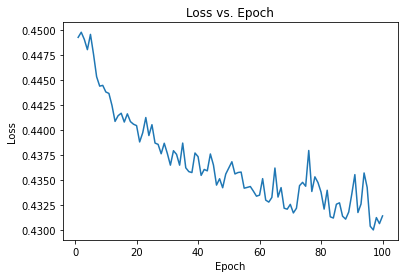

In [237]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()


In [238]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on test set: {accuracy * 100}%')


Accuracy on test set: 89.47368421052632%
